# Word2vec only with one matrix

Choose CBOW/Skip-Gram again. Implement it, but now without second `h_dim x vocab_size` matrix. Remember what was the loss function in Stanford lecture.

$$ L = - \frac{1}{T} \sum_{t=1}^T \sum_{-m <= j <= m, j \ne 0} log P(w_{t+j}|w_{t+j-m})$$


$$ P(w_h | w_i) = \frac{exp(s(v_i, v_h))}{\sum exp(s(v_i, v_w))}$$

Where $s(x, y)$ is a similarity function. It is common to use dot-product here $s(x, y) = s^Ty$. The sum in the denominator is across all vocabulary for $P$ to be a probability distribution.

Look to this formula closer. There is no projection back to vocabulary dimension in the loss! So, we can reduce the number of parameters by the factor of two by not using the second matrix $W'$. Your new task is to code CBOW / SkipGram with this loss.

**Main idea:**

We project word vectors to some space. Next, we work with the space itself. We update projection matrix weights so that similar (in the terms of Distributional semantics) words have similar vectors in that space. We don't need to solve classification task explicitly here.

**Tip:**

Work with matrix operations and not with nn.layers / keras.layers.

**Results of this task** (the very same as in task 3):
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies


**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)



Supplementary materials:
  * [cs224n winter 2017 lecture 2 video](https://www.youtube.com/watch?v=ERibwqs9p38&list=PL3FW7Lu3i5Jsnh1rnUwq_TcylNr7EkRe6&index=2)
  * [cs224n winter 2019 lecture 1 slides](http://web.stanford.edu/class/cs224n/slides/cs224n-2019-lecture01-wordvecs1.pdf)

In [1]:
import torch
import numpy as np
from torch import nn
import torch.autograd

from tqdm import tqdm_notebook as tqdm  # because I love progress bars
import time
from typing import List, Iterable, Tuple

from utils import SkipGramDataGen, Vocab, preprocess

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
device = torch.device("cuda")

In [3]:
def batch_dot(a, b):
    """
    Calculate dot product between vectors in a batch
    """
    return torch.sum(a * b, dim=1)

class SkipGramOneMatrix(nn.Module):
    """
    Implementing naive skip-gram with only one weight matrix and some
    monstruous functions.
    """
    def __init__(self, vocab_size: int, emb_size: int):
        super(SkipGramOneMatrix, self).__init__()
        self.emb = torch.empty((vocab_size + 1, emb_size), dtype=torch.float, requires_grad=True, device=device)
        nn.init.xavier_normal_(self.emb)
    
    def forward(self, x, y):
        word_vec = self.emb[[x]]
        context_vec = self.emb[[y]]
        sims = torch.exp(batch_dot(word_vec, context_vec))
        all_sims = torch.sum(torch.exp(self.emb @ word_vec.t()), dim=0)
        # we could use mean, but let's use sum just for a change
        loss = -torch.sum(torch.log(sims / all_sims))
        return loss

In [4]:
with open("text8/text8", encoding="utf-8") as f:
    tokens = preprocess(f.read())

In [5]:
# training parameters go here
vocab_size = 30000
window_size = 5
emb_size = 150
batch_size = 256
n_epochs = 3

lr = 3e-4

In [6]:
vocab = Vocab(vocab_size)

In [7]:
vocab.build([tokens])

In [8]:
data = SkipGramDataGen([vocab.numericalize(tokens)], window_size)

In [9]:
model = SkipGramOneMatrix(vocab_size, emb_size)

In [10]:
model.to(device)

SkipGramOneMatrix()

In [11]:
def epoch(model: nn.Module, 
          data: SkipGramDataGen, 
          loss_history: List, 
          optimizer, 
          device, 
          bs=128, 
          report_every=3000):
    """
    Run one epoch of training the `model` on `data`.
    Loss values for plotting are saved in `loss_history`.
    Average batch loss is printed every `report_every` epochs.
    """
    start = time.time()
    running_loss = list()
    for i, (x, y) in enumerate(tqdm(data.iter_batch(bs))):
        optimizer.zero_grad()

        x = torch.tensor(x, dtype=torch.long).to(device)
        y = torch.tensor(y, dtype=torch.long).to(device)
        loss = model.forward(x, y)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.detach().item())
        if (i + 1) % report_every == 0:
            avg_loss = sum(running_loss) / len(running_loss)
            print("Step {}, loss: {}".format(i + 1, avg_loss))
            loss_history.append(avg_loss)
            running_loss = list()
    print("Done. Time: {}. Loss: {}.".format(time.time() - start, sum(running_loss) / len(running_loss)))

In [12]:
optimizer = torch.optim.Adam([model.emb], lr=lr)

In [13]:
loss_history = list()

In [14]:
for i in range(n_epochs):
    print("Epoch", i)
    epoch(model, data, loss_history, optimizer, device, bs=batch_size)

Epoch 0


Step 3000, loss: 2325.173334513346
Step 6000, loss: 2148.6599114176433
Step 9000, loss: 2116.863825032552
Step 12000, loss: 2075.8498862304687
Step 15000, loss: 2044.8669871012369
Step 18000, loss: 2033.2776995849608
Step 21000, loss: 2042.966075439453
Step 24000, loss: 2026.5704173177082
Step 27000, loss: 1997.3315909220378
Step 30000, loss: 1993.380203857422
Step 33000, loss: 1989.216983601888
Step 36000, loss: 1982.9000609537761
Step 39000, loss: 1969.5830196329753
Step 42000, loss: 1980.1956293131511
Step 45000, loss: 1975.1466612955728
Step 48000, loss: 1958.3181770629883
Step 51000, loss: 1904.287537068685
Step 54000, loss: 1941.3483610026042
Step 57000, loss: 1961.3153204752605
Step 60000, loss: 1978.7149431559244
Step 63000, loss: 1926.7557246704102
Step 66000, loss: 1950.6998070882162

Done. Time: 1185.771110534668. Loss: 2002.340636778213.
Epoch 1


Step 3000, loss: 1955.8210080566407
Step 6000, loss: 1926.8565861002605
Step 9000, loss: 1954.214504760742
Step 12000, loss: 1952.8330803629558
Step 15000, loss: 1950.9229235839844
Step 18000, loss: 1953.6765803629557
Step 21000, loss: 1977.9598466389973
Step 24000, loss: 1975.1037774251301
Step 27000, loss: 1951.8381572062174
Step 30000, loss: 1951.895658162435
Step 33000, loss: 1955.86231254069
Step 36000, loss: 1952.6009936116536
Step 39000, loss: 1942.472789001465
Step 42000, loss: 1958.4637911376954
Step 45000, loss: 1956.2781853637696
Step 48000, loss: 1942.8809385986328
Step 51000, loss: 1888.7258759155272
Step 54000, loss: 1928.4073980305989
Step 57000, loss: 1947.002980061849
Step 60000, loss: 1966.51071870931
Step 63000, loss: 1915.0815887451172
Step 66000, loss: 1940.2315896402995

Done. Time: 1161.3639965057373. Loss: 1989.9780670809243.
Epoch 2


Step 3000, loss: 1948.3315279947917
Step 6000, loss: 1918.046971110026
Step 9000, loss: 1947.1770353597005
Step 12000, loss: 1945.5101733805338
Step 15000, loss: 1945.1744446411133
Step 18000, loss: 1945.9693068033855
Step 21000, loss: 1969.4101606852214
Step 24000, loss: 1966.7991874186198
Step 27000, loss: 1944.6560102132162
Step 30000, loss: 1945.2475254313151
Step 33000, loss: 1948.4071530354818
Step 36000, loss: 1947.5697858479818
Step 39000, loss: 1938.860860188802
Step 42000, loss: 1954.2034253743489
Step 45000, loss: 1951.337952006022
Step 48000, loss: 1938.7610219930013
Step 51000, loss: 1882.2557262369792
Step 54000, loss: 1923.1968141682942
Step 57000, loss: 1943.023236735026
Step 60000, loss: 1962.1918896484376
Step 63000, loss: 1911.735500854492
Step 66000, loss: 1937.3858123372395

Done. Time: 1164.2975225448608. Loss: 1982.1739510529494.


### 1. Trained word vectors 

This algorithm was trained in less than an hour - probably because there were no one-hot vectors involved, and the number of parameters was half the previous model.

In [15]:
embs = model.emb.detach().cpu().numpy()

In [60]:
embs.shape

(30001, 150)

In [21]:
np.save("embeddings_one_matrix.np", embs)

In [22]:
import pickle

with open("vocab_one_matrix.pkl", "wb") as f:
    pickle.dump(vocab.itos, f)

### 2. Plotted loss

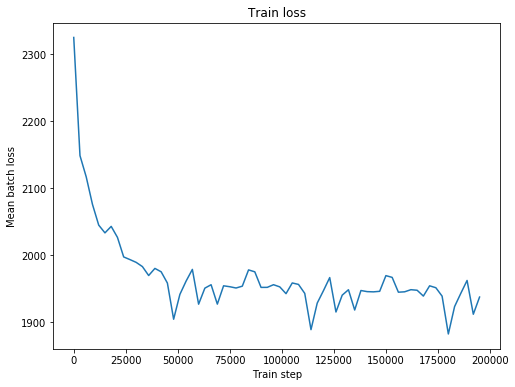

In [23]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=[3000*i for i in range(len(loss_history))], y=loss_history)
plt.title("Train loss")
plt.ylabel("Mean batch loss")
plt.xlabel("Train step")
plt.show()

### 3. Function to map token to corresponding word vector

In [24]:
def get_vector(word: str, vocab: Vocab, embeddings: np.array):
    assert word in vocab.stoi, "Word is not in the vocabulary"
    i = vocab.stoi[word]
    vec = embeddings[i]
    return vec

In [25]:
get_vector("russia", vocab, embs).shape

(150,)

### 4. Beautiful visualizations (PCE, T-SNE)

In [16]:
def most_similar(word: str, vocab: Vocab, embeddings: np.ndarray, n_similar: int) -> List[Tuple[str, int]]:
    assert word in vocab.stoi, "Word is not in the vocabulary"
    i = vocab.stoi[word]
    vec = embeddings[i]
    # cosine similarity measure:
    sims = embeddings @ vec.T \
        / (np.sqrt(np.sum(np.square(embeddings), axis=1)) \
           * np.sqrt(np.sum(np.square(vec)))) 
    i_to_sim = zip(vocab.itos, sims)
    words_by_sim = sorted(i_to_sim, key=lambda x: x[1], reverse=True)
    return list(words_by_sim)[:n_similar]

In [26]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA(2)
pca.fit(embs)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [29]:
def visualize(embeddings, vocab, words, num_neihgbors, pca):
    clusters = list()
    for word in words:
        clusters.append(most_similar(word, vocab, embeddings, num_neihgbors))

    vectors, labels, sims, hues = list(), list(), list(), list()
    for i, cluster in enumerate(clusters):
        for w, s in cluster:
            vectors.append(get_vector(w, vocab, embeddings))
            labels.append(w)
            sims.append(s)
            hues.append(i)

    transformed = pca.transform(np.stack(vectors))
    
    return transformed[:, 0], transformed[:, 1], labels, sims, hues

Let's look at some different clusters:

In [36]:
words_to_vis = ["capitalism", "father", "law"]

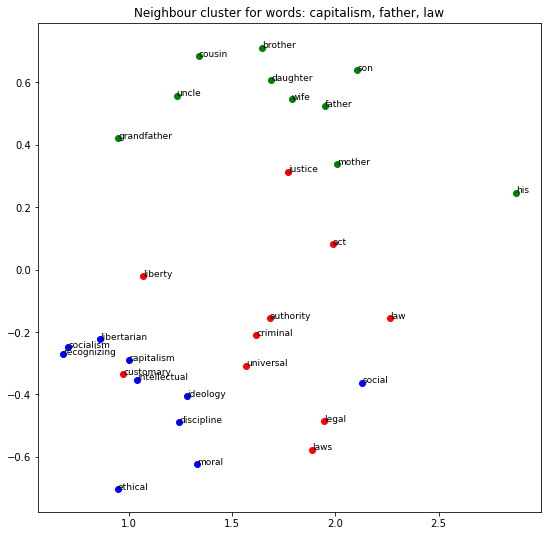

In [37]:
x, y, labels, sims, hues = visualize(embs, vocab, words_to_vis, 10, pca)

plt.figure(figsize=(9, 9))
plt_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # this is how many clusters you can get
offs = 0.02

for i in range(len(labels)):
    plt.scatter(x[i], y[i], c=plt_colors[hues[i]])
    plt.text(x[i] + offs, y[i] + offs, labels[i], fontsize=9)

plt.title(f"Neighbour cluster for words: {', '.join(words_to_vis)}")
plt.show()

### 5. Qualitative evaluations of word vectors: nearest neighbors, word analogies

In [38]:
def most_similar_to_vec(vec, vocab, embeddings, n_similar):
    sims = embeddings @ vec.T \
        / (np.sqrt(np.sum(np.square(embeddings), axis=1)) \
           * np.sqrt(np.sum(np.square(vec)))) 
    i_to_sim = zip(vocab.itos, sims)
    words_by_sim = sorted(i_to_sim, key=lambda x: x[1], reverse=True)
    return list(words_by_sim)[:n_similar]

def solve_analogy(embeddings: np.ndarray, vocab: Vocab, task: List[str]) -> Tuple[str, float]:
    """
    Return the word d from `a to b is like c to d`, given a, b, c in the task list
    """
    indices = [vocab.stoi[w] for w in task]
    vectors = embeddings[indices]
    query = vectors[1] - vectors[0] + vectors [2]
    closest = most_similar_to_vec(query, vocab, embeddings, 4)
    for c in closest:
        if c[0] not in task:
            return c

#### Nearest neighbours 

In [17]:
most_similar("russia", vocab, embs, 10)

[('russia', 0.9999999),
 ('poland', 0.95411754),
 ('germany', 0.93996793),
 ('romania', 0.9370792),
 ('france', 0.9361911),
 ('hungary', 0.9359765),
 ('finland', 0.93475527),
 ('portugal', 0.93452734),
 ('spain', 0.9325839),
 ('turkey', 0.9162919)]

In [18]:
most_similar("mother", vocab, embs, 10)

[('mother', 0.99999994),
 ('father', 0.9687309),
 ('sister', 0.9451929),
 ('wife', 0.94455624),
 ('daughter', 0.93401986),
 ('her', 0.928826),
 ('brother', 0.9272099),
 ('son', 0.92089665),
 ('his', 0.9118751),
 ('uncle', 0.9100779)]

In [20]:
most_similar("she", vocab, embs, 10)

[('she', 1.0),
 ('her', 0.9417131),
 ('he', 0.91102064),
 ('caught', 0.9012594),
 ('herself', 0.89947015),
 ('child', 0.8992324),
 ('victim', 0.8915219),
 ('reportedly', 0.887525),
 ('baby', 0.8866162),
 ('woman', 0.87685895)]

Replicate the ones from Task 3:

In [40]:
task = ["son", "brother", "daughter"]
solve_analogy(embs, vocab, task)

('sister', 0.9068825)

In [42]:
task = ["paris", "france", "moscow"]
solve_analogy(embs, vocab, task)

('russia', 0.93941396)

This one is beautiful:

In [54]:
task = ["snow", "winter", "rain"]
solve_analogy(embs, vocab, task)

('summer', 0.8790044)

### Extra: intrinsic evaluation with Google analogies 

In [55]:
with open("questions-words.txt", encoding="utf-8") as f:
    pairs = f.read().strip().lower().split("\n")

In [56]:
from collections import defaultdict
tasks = defaultdict(list)

current_task = ""
for line in pairs:
    line = line.strip()
    if line.startswith(":"):
        current_task = line
    else:
        tasks[current_task].append(line.split(" "))

In [66]:
stats = dict()
for task in tasks:
    stats[task] = {"total": len(tasks[task]), "done": 0, "not_found": 0}
    for t in tasks[task]:
        try:
            res, _ = solve_analogy(embs, vocab, t[:3])
            if res == t[3]:
                stats[task]["done"] += 1
        except KeyError as e:
            stats[task]["not_found"] += 1# some of the words are not found in the vocab, so we don't get a point

In [67]:
stats

{': capital-common-countries': {'total': 506, 'done': 49, 'not_found': 0},
 ': capital-world': {'total': 4524, 'done': 68, 'not_found': 3072},
 ': currency': {'total': 866, 'done': 0, 'not_found': 377},
 ': city-in-state': {'total': 2467, 'done': 120, 'not_found': 896},
 ': family': {'total': 506, 'done': 92, 'not_found': 164},
 ': gram1-adjective-to-adverb': {'total': 992, 'done': 21, 'not_found': 124},
 ': gram2-opposite': {'total': 812, 'done': 8, 'not_found': 326},
 ': gram3-comparative': {'total': 1332, 'done': 168, 'not_found': 36},
 ': gram4-superlative': {'total': 1122, 'done': 17, 'not_found': 386},
 ': gram5-present-participle': {'total': 1056, 'done': 108, 'not_found': 32},
 ': gram6-nationality-adjective': {'total': 1599,
  'done': 230,
  'not_found': 117},
 ': gram7-past-tense': {'total': 1560, 'done': 80, 'not_found': 117},
 ': gram8-plural': {'total': 1332, 'done': 99, 'not_found': 244},
 ': gram9-plural-verbs': {'total': 870, 'done': 31, 'not_found': 116}}

In [68]:
done = 0
total = 0
for stat in stats:
    name = stat
    stat = stats[name]
    acc = stat["done"] / stat["total"]
    done += stat["done"]
    total += stat["total"]
    print(f"{name}: {acc: .2%}")
print(f"Total: {done/total: .2%}")

: capital-common-countries:  9.68%
: capital-world:  1.50%
: currency:  0.00%
: city-in-state:  4.86%
: family:  18.18%
: gram1-adjective-to-adverb:  2.12%
: gram2-opposite:  0.99%
: gram3-comparative:  12.61%
: gram4-superlative:  1.52%
: gram5-present-participle:  10.23%
: gram6-nationality-adjective:  14.38%
: gram7-past-tense:  5.13%
: gram8-plural:  7.43%
: gram9-plural-verbs:  3.56%
Total:  5.58%
